In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm
def expectation_probabilities_gmm(data, mean_vect, sd_vect, fracPerComp):
    ret_probs = np.zeros([len(data),len(mean_vect)])
    for i in range(len(data)):
        for j in range(len(mean_vect)):
            ret_probs[i,j] = (fracPerComp[j]*norm.pdf(data[i],mean_vect[j],sd_vect[j]))
        ret_probs[i,:] = ret_probs[i,:]/np.sum(ret_probs[i,:])
    return(ret_probs)

In [ ]:
def maximization_params_gmm(expect_probs, data):
    clust_weights = [np.sum(expect_probs[:,j]) for j in
        range(np.shape(expect_probs)[1])]
    new_means = np.divide([np.sum(expect_probs[:,j]*data[:]) for
        j in range(np.shape(expect_probs)[1])],clust_weights)
    new_sds = np.divide([np.sum(expect_probs[:,j]*(data[:]-new_means[j])*(data[:]-new_means[j])) for j in range(np.shape(expect_probs)[1]) ], clust_weights)
    new_sds = np.sqrt(new_sds)
    new_frac = np.divide(clust_weights,np.shape(expect_probs)[0])
    return new_means, new_sds, new_frac;

In [ ]:
def log_likelihood(data, mean_vect, sd_vect, fracPerComp):
  ret_probs = np.zeros([len(data),len(mean_vect)])
  for i in range(len(data)):
      for j in range(len(mean_vect)):
          ret_probs[i,j] = (fracPerComp[j]*norm.pdf(data[i],mean_vect[j],sd_vect[j]))
      row_sums = np.sum(ret_probs[i,:])
  loglike = np.sum(np.log(row_sums))
  return(loglike)

In [ ]:
np.random.seed(seed=123987) #reproducibility
vals = [np.random.normal(5, .5, 100), np.random.normal(3, 1, 100), np.random.normal(6.5,1.25,100)]
grps = ['A','B','C']
#build dataframe
df = pd.concat([pd.DataFrame({"group":grps[i], "value":vals[i]}) for i in range(0,3)], axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/dis

<Figure size 216x216 with 0 Axes>

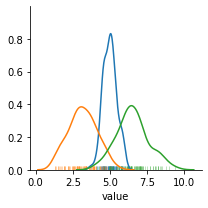

In [ ]:
#grouped
plt.figure(figsize=(3,3))
plots = sns.FacetGrid(data=df, hue="group", legend_out=True)
plots.map(sns.distplot,'value', kde_kws={"shade":False},rug_kws={"alpha":.3}, rug=True, kde=True, hist=False)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


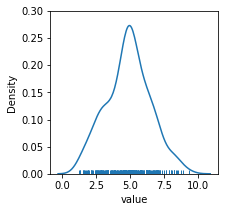

In [ ]:
plt.close() #get a blank plot rather than overlay on our last distplots
plt.figure(figsize=(3,3))
sns.distplot(df['value'], rug=True, kde=True, hist=False)
plt.show()

In [ ]:
##Shapiro-Wilkes test
print(scipy.stats.shapiro(df['value']))

(0.9909396767616272, 0.0613214448094368)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/dis

<Figure size 216x216 with 0 Axes>

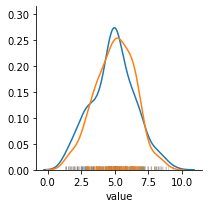

In [ ]:
##compare with true normal sample
simDF = pd.DataFrame({"type":"simulated", "value":np.random.normal(df['value'].mean(), df['value'].std(), 300)})
simDF = pd.concat([pd.DataFrame({"type":"sample", "value":df['value']}), simDF], axis=0, ignore_index=True)
plt.figure(figsize=(3,3))
plotsim = sns.FacetGrid(data=simDF, hue="type")
plotsim.map(sns.distplot,'value', kde_kws={"shade":False},rug_kws={"alpha":.3}, rug=True, kde=True, hist=False)
plt.show()

In [ ]:
def run_em(data, init_means, init_sds, init_frac, num_iterations):
    ret_means = np.zeros((num_iterations,len(init_means)))
    ret_sds = np.zeros((num_iterations,len(init_means)))
    ret_fracs = np.zeros((num_iterations,len(init_means)))
    ret_ll = np.zeros(num_iterations)
    ret_means[0,:] = init_means
    ret_sds[0,:] = init_sds
    ret_fracs[0,:] = init_frac
    for i in range(num_iterations-1):
        ret_ll[i]=log_likelihood(data, ret_means[i,:],ret_sds[i,:], ret_fracs[i,:])
        new_probs = expectation_probabilities_gmm(data, ret_means[i,:],ret_sds[i,:], ret_fracs[i,:])
        ret_means[i+1,:], ret_sds[i+1,:],ret_fracs[i+1,:] = maximization_params_gmm(new_probs, data)
    return ret_means, ret_sds, ret_fracs, ret_ll;

In [ ]:
means = [3,5.5, 7]
sds = [1,1,1]
fracs = [1/3,1/3,1/3]
mu,sigma,frac,ll = run_em(df['value'], means, sds, fracs, 50)

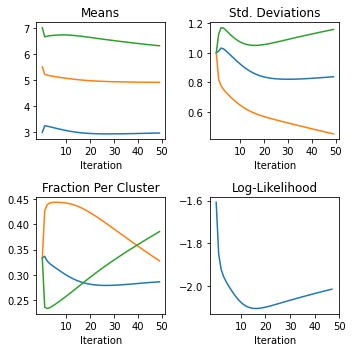

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
plt.plot(mu)
plt.title("Means")
plt.xlabel("Iteration")
plt.xticks([10*(i+1) for i in range(5)])
plt.subplot(2,2,2)
plt.plot(sigma)
plt.title("Std. Deviations")
plt.xlabel("Iteration")
plt.xticks([10*(i+1) for i in range(5)])
plt.subplot(2,2,3)
plt.plot(frac)
plt.title("Fraction Per Cluster")
plt.xlabel("Iteration")
plt.xticks([10*(i+1) for i in range(5)])
plt.subplot(2,2,4)
plt.plot(ll[0:48]) #last ll value hasn't been calculated
plt.title("Log-Likelihood")
plt.xlabel("Iteration")
plt.xticks([10*(i+1) for i in range(5)])
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm
np.random.seed(0)

X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+10 # Create data cluster 1
X1 = X*np.random.rand(len(X))-10 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above



"""Create the array r with dimensionality nxK"""
r = np.zeros((len(X_tot),3))  
print('Dimensionality','=',np.shape(r))

"""Instantiate the random gaussians"""

gauss_1 = norm(loc=-5,scale=5) 
gauss_2 = norm(loc=8,scale=3)
gauss_3 = norm(loc=1.5,scale=1)

"""
Probability for each datapoint x_i to belong to gaussian g 
"""
for c,g in zip(range(3),[gauss_1,gauss_2,gauss_3]):
    r[:,c] = g.pdf(X_tot) # Write the probability that x belongs to gaussian c in column c. 
                          # Therewith we get a 60x3 array filled with the probability that each x_i belongs to one of the gaussians
"""
Normalize the probabilities such that each row of r sums to 1
"""
for i in range(len(r)):
    r[i] = r[i]/np.sum(r,axis=1)[i] 

"""In the last calculation we normalized the probabilites r_ic. So each row i in r gives us the probability for x_i 
to belong to one gaussian (one column per gaussian). Since we want to know the probability that x_i belongs 
to gaussian g, we have to do smth. like a simple calculation of percentage where we want to know how likely it is in % that
x_i belongs to gaussian g. To realize this, we must dive the probability of each r_ic by the total probability r_i (this is done by 
summing up each row in r and divide each value r_ic by sum(np.sum(r,axis=1)[r_i] )). To get this,
look at the above plot and pick an arbitrary datapoint. Pick one gaussian and imagine the probability that this datapoint
belongs to this gaussian. This value will normally be small since the point is relatively far away right? So what is
the percentage that this point belongs to the chosen gaussian? --> Correct, the probability that this datapoint belongs to this 
gaussian divided by the sum of the probabilites for this datapoint for all three gaussians."""
    
print(r)
print(np.sum(r,axis=1)) # As we can see, as result each row sums up to one, just as we want it.

Dimensionality = (60, 3)
[[2.97644006e-02 9.70235407e-01 1.91912550e-07]
 [3.85713024e-02 9.61426220e-01 2.47747304e-06]
 [2.44002651e-02 9.75599713e-01 2.16252823e-08]
 [1.86909096e-02 9.81309090e-01 8.07574590e-10]
 [1.37640773e-02 9.86235923e-01 9.93606589e-12]
 [1.58674083e-02 9.84132592e-01 8.42447356e-11]
 [1.14191259e-02 9.88580874e-01 4.48947365e-13]
 [1.34349421e-02 9.86565058e-01 6.78305927e-12]
 [1.11995848e-02 9.88800415e-01 3.18533028e-13]
 [8.57645259e-03 9.91423547e-01 1.74498648e-15]
 [7.64696969e-03 9.92353030e-01 1.33051021e-16]
 [7.10275112e-03 9.92897249e-01 2.22285146e-17]
 [6.36154765e-03 9.93638452e-01 1.22221112e-18]
 [4.82376290e-03 9.95176237e-01 1.55549544e-22]
 [7.75866904e-03 9.92241331e-01 1.86665135e-16]
 [7.52759691e-03 9.92472403e-01 9.17205413e-17]
 [8.04550643e-03 9.91954494e-01 4.28205323e-16]
 [3.51864573e-03 9.96481354e-01 9.60903037e-30]
 [3.42631418e-03 9.96573686e-01 1.06921949e-30]
 [3.14390460e-03 9.96856095e-01 3.91217273e-35]
 [1.00000000e+0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

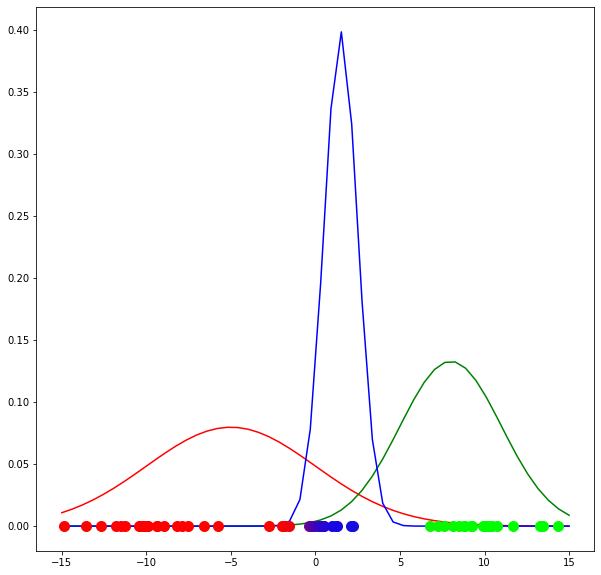

In [ ]:

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


for i in range(len(r)):
    ax0.scatter(X_tot[i],0,c=np.array([r[i][0],r[i][1],r[i][2]]),s=100) # We have defined the first column as red, the second as
                                                                        # green and the third as blue



for g,c in zip([gauss_1.pdf(np.linspace(-15,15)),gauss_2.pdf(np.linspace(-15,15)),gauss_3.pdf(np.linspace(-15,15))],['r','g','b']):
    ax0.plot(np.linspace(-15,15),g,c=c,zorder=0)

    
    
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

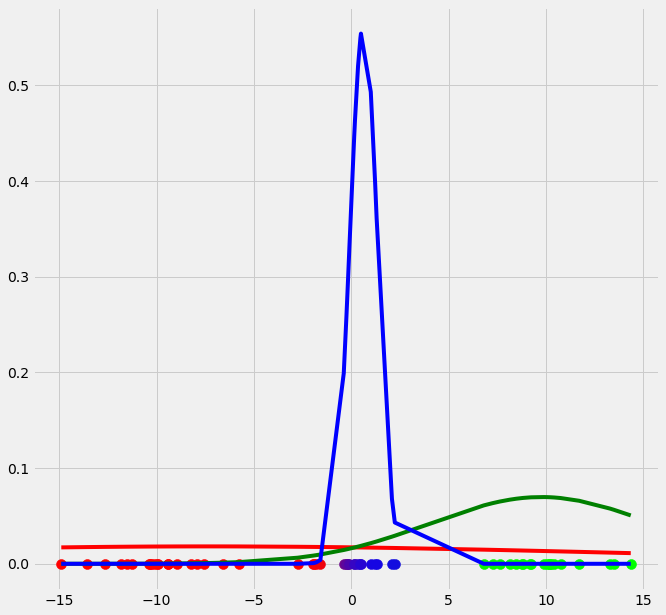

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import norm
np.random.seed(0)

X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+10 # Create data cluster 1
X1 = X*np.random.rand(len(X))-10 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X_tot = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random datapoints from above

"""
E-Step
"""

"""Create the array r with dimensionality nxK"""
r = np.zeros((len(X_tot),3))  

"""Instantiate the random gaussians"""

gauss_1 = norm(loc=-5,scale=5) 
gauss_2 = norm(loc=8,scale=3)
gauss_3 = norm(loc=1.5,scale=1)

"""Instantiate the random mu_c"""
m = np.array([1/3,1/3,1/3]) # We expect to have three clusters 

pi = m/np.sum(m)


"""
Probability for each datapoint x_i to belong to gaussian g 
"""
for c,g,p in zip(range(3),[gauss_1,gauss_2,gauss_3],pi):
    r[:,c] = p*g.pdf(X_tot) # Write the probability that x belongs to gaussian c in column c. 
                          # Therewith we get a 60x3 array filled with the probability that each x_i belongs to one of the gaussians
"""
Normalize the probabilities such that each row of r sums to 1 and weight it by mu_c == the fraction of points belonging to 
cluster c
"""
for i in range(len(r)):
    r[i] = r[i]/(np.sum(pi)*np.sum(r,axis=1)[i])


"""M-Step"""


"""calculate m_c"""
m_c = []
for c in range(len(r[0])):
    m = np.sum(r[:,c])
    m_c.append(m) # For each cluster c, calculate the m_c and add it to the list m_c
    
"""calculate pi_c"""
pi_c = []
for m in m_c:
    pi_c.append(m/np.sum(m_c)) # For each cluster c, calculate the fraction of points pi_c which belongs to cluster c

"""calculate mu_c"""
mu_c = np.sum(X_tot.reshape(len(X_tot),1)*r,axis=0)/m_c


"""calculate var_c"""
var_c = []

for c in range(len(r[0])):
    var_c.append((1/m_c[c])*np.dot(((np.array(r[:,c]).reshape(60,1))*(X_tot.reshape(len(X_tot),1)-mu_c[c])).T,(X_tot.reshape(len(X_tot),1)-mu_c[c])))
  

    
    
"""Update the gaussians"""

gauss_1 = norm(loc=mu_c[0],scale=var_c[0]) 
gauss_2 = norm(loc=mu_c[1],scale=var_c[1])
gauss_3 = norm(loc=mu_c[2],scale=var_c[2])



"""Plot the data"""

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


for i in range(len(r)):
    ax0.scatter(X_tot[i],0,c=np.array([r[i][0],r[i][1],r[i][2]]),s=100) 


"""Plot the gaussians"""


for g,c in zip([gauss_1.pdf(np.sort(X_tot).reshape(60,1)),gauss_2.pdf(np.sort(X_tot).reshape(60,1)),gauss_3.pdf(np.sort(X_tot).reshape(60,1))],['r','g','b']):
    ax0.plot(np.sort(X_tot),g,c=c)

    

    
plt.show()